In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import time, datetime
from itertools import cycle, islice
import warnings

In [2]:
def fasta_to_dataframe(f):
    fasta_df = pd.read_csv(f,sep='>', lineterminator='>',header=None)
    fasta_df[['Accession','Sequence']]=fasta_df[0].str.split('\n', 1, expand=True)
    fasta_df['Accession'] = '>' + fasta_df['Accession']
    fasta_df['Sequence'] = fasta_df['Sequence'].replace('\n','', regex=True)
    fasta_df.drop(0, axis=1, inplace=True)
    fasta_df.set_index('Accession',inplace=True)
    fasta_df = fasta_df[fasta_df.Sequence != '']
    final_df = fasta_df.dropna()
    return final_df

def convert_time(t):
    x = time.strptime(t,'%H:%M:%S')
    return str(int(datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()))

In [3]:
# find 10 sequences with a large range of lengths
(2389-36)/11

213.9090909090909

In [4]:
length = []
for i in list(range(0,11)):
    l = 36+(i*213)
    length.append(l)

In [5]:
length.append(2389)

In [6]:
length

[36, 249, 462, 675, 888, 1101, 1314, 1527, 1740, 1953, 2166, 2389]

In [7]:
d = pd.concat([fasta_to_dataframe('ecoli_W3110_tags.faa'), fasta_to_dataframe('pET15_NESG.faa'), fasta_to_dataframe('pET21_NESG.faa')])

In [8]:
d['Length'] = d.Sequence.str.len()

In [9]:
l = []
for i in length:
    unique_length = np.array(d.Length.unique())
    closest_length = (np.abs(unique_length-i)).argmin()
    l.append(unique_length[closest_length])

In [10]:
l

[36, 249, 462, 675, 888, 1095, 1315, 1539, 1675, 1675, 2389, 2389]

In [11]:
l = list(dict.fromkeys(l))

In [12]:
l = pd.DataFrame(l, columns = ['Length'])

In [13]:
d = pd.merge(d.reset_index(), l, on='Length').drop_duplicates(subset=['Length'])
d['fasta'] = d.Accession + '\n' + d.Sequence
d['fasta'].to_csv('benchmark.fa', header= False, index= False, sep = '\t', quoting = csv.QUOTE_NONE, escapechar = ' ')

```console
# split multi-fasta into single fasta files
cd /nesi/nobackup/uoo00123/
mkdir benchmark
cd benchmark

../kentUtils/bin/faSplit byname ../benchmark.fa .
for i in *.fa; do \
  mkdir ${i%.*}
  mv ${i} ${i%.*}
done
```

```console
# PaRSnIP

module load R/3.6.1-gimkl-2018b
module load Java/1.8.0_144
export R_LIBS_USER='/nesi/project/uoo00123/R/x86_64-centos-linux-gnu-library/3.6'
export PERL5LIB="${PERL5LIB}:/home/limch05p/perl5/lib/"
for i in `grep '>' /nesi/nobackup/uoo00123/benchmark.fa | sed 's/>//'`; do \
  cd /nesi/nobackup/uoo00123/benchmark/${i}
  /usr/bin/time R --vanilla \
  < /nesi/project/uoo00123/PaRSnIP/PaRSnIP.R ${i}.fa \
  /nesi/project/uoo00123/SCRATCH-1D_1.2/bin/run_SCRATCH-1D_predictors.sh \
  /nesi/project/uoo00123/PaRSnIP/PaRSnIP_training_model
done 2>&1 | tee PaRSnIP_1.txt;
for i in `grep '>' /nesi/nobackup/uoo00123/benchmark.fa | sed 's/>//'`; do \
  cd /nesi/nobackup/uoo00123/benchmark/${i}
  /usr/bin/time R --vanilla \
  < /nesi/project/uoo00123/PaRSnIP/PaRSnIP.R ${i}.fa \
  /nesi/project/uoo00123/SCRATCH-1D_1.2/bin/run_SCRATCH-1D_predictors.sh \
  /nesi/project/uoo00123/PaRSnIP/PaRSnIP_training_model
done 2>&1 | tee PaRSnIP_2.txt;
for i in `grep '>' /nesi/nobackup/uoo00123/benchmark.fa | sed 's/>//'`; do \
  cd /nesi/nobackup/uoo00123/benchmark/${i}
  /usr/bin/time R --vanilla \
  < /nesi/project/uoo00123/PaRSnIP/PaRSnIP.R ${i}.fa \
  /nesi/project/uoo00123/SCRATCH-1D_1.2/bin/run_SCRATCH-1D_predictors.sh \
  /nesi/project/uoo00123/PaRSnIP/PaRSnIP_training_model
done 2>&1 | tee PaRSnIP_3.txt;

for i in 1 2 3; do \
    paste \
    <(awk '/__ignored__/ && /fa/' PaRSnIP_${i}.txt) \
    <(grep user PaRSnIP_${i}.txt) \
    | awk '{gsub(/\047/,""); sub(/\.fa/,""); sub("elapsed",""); print $2 "\t" $6}' \
    > PaRSnIP_${i}_lapsed.txt
    cat \
    <(grep -v "\." PaRSnIP_${i}_lapsed.txt | sed 's/:/\t/g') \
    <(grep "\." PaRSnIP_${i}_lapsed.txt | sed 's/:/\t/' \
    | awk 'BEGIN{OFS="\t"} {print $1,"00",$2,$3}') > PaRSnIP_${i}_elapsed.txt
    rm PaRSnIP_${i}_lapsed.txt
done
cat PaRSnIP_*_elapsed.txt > benchmark_PaRSnIP.txt
```

```console
# DeepSol

module load R/3.6.1-gimkl-2018b
module load Java/1.8.0_144
export R_LIBS_USER='/nesi/project/uoo00123/R/x86_64-centos-linux-gnu-library/3.6'
export PERL5LIB="${PERL5LIB}:/home/limch05p/perl5/lib/"
export PATH="/nesi/nobackup/uoo00123/anaconda3/bin:$PATH"

cd /nesi/nobackup/uoo00123/DSOL_rv0.2
for i in `grep '>' /nesi/nobackup/uoo00123/benchmark.fa | sed 's/>//'`; do \
    /usr/bin/time R --vanilla \
    < /nesi/nobackup/uoo00123/DSOL_rv0.2/scripts/PaRSnIP.R \
    /nesi/nobackup/uoo00123/benchmark/${i}/${i}.fa \
    /nesi/project/uoo00123/avoidance/doc/SCRATCH-1D_1.2/bin/run_SCRATCH-1D_predictors.sh \
    ${i} 1

    /usr/bin/time ./run.sh --model deepsol1 --stage 1 --mode preprocess --device cpu --test_file ${i} data/deepsol1_${i}.data
    /usr/bin/time ./run.sh --model deepsol2 --stage 1 --mode preprocess --device cpu --test_file ${i} data/deepsol2_${i}.data
    /usr/bin/time ./run.sh --model deepsol3 --stage 1 --mode preprocess --device cpu --test_file ${i} data/deepsol3_${i}.data
    
    /usr/bin/time ./run.sh --model deepsol1 --stage 2 --mode decode --device cpu data/deepsol1_${i}.data
    /usr/bin/time ./run.sh --model deepsol2 --stage 2 --mode decode --device cpu data/deepsol2_${i}.data
    /usr/bin/time ./run.sh --model deepsol3 --stage 2 --mode decode --device cpu data/deepsol3_${i}.data
    rm -r ~/.theano/
done 2>&1 | tee DSOL_1.txt;

for i in `grep '>' /nesi/nobackup/uoo00123/benchmark.fa | sed 's/>//'`; do \
    /usr/bin/time R --vanilla \
    < /nesi/nobackup/uoo00123/DSOL_rv0.2/scripts/PaRSnIP.R \
    /nesi/nobackup/uoo00123/benchmark/${i}/${i}.fa \
    /nesi/project/uoo00123/avoidance/doc/SCRATCH-1D_1.2/bin/run_SCRATCH-1D_predictors.sh \
    ${i} 1
    
    /usr/bin/time ./run.sh --model deepsol1 --stage 1 --mode preprocess --device cpu --test_file ${i} data/deepsol1_${i}.data
    /usr/bin/time ./run.sh --model deepsol2 --stage 1 --mode preprocess --device cpu --test_file ${i} data/deepsol2_${i}.data
    /usr/bin/time ./run.sh --model deepsol3 --stage 1 --mode preprocess --device cpu --test_file ${i} data/deepsol3_${i}.data
    
    /usr/bin/time ./run.sh --model deepsol1 --stage 2 --mode decode --device cpu data/deepsol1_${i}.data
    /usr/bin/time ./run.sh --model deepsol2 --stage 2 --mode decode --device cpu data/deepsol2_${i}.data
    /usr/bin/time ./run.sh --model deepsol3 --stage 2 --mode decode --device cpu data/deepsol3_${i}.data
    rm -r ~/.theano/
done 2>&1 | tee DSOL_2.txt;

for i in `grep '>' /nesi/nobackup/uoo00123/benchmark.fa | sed 's/>//'`; do \
    /usr/bin/time R --vanilla \
    < /nesi/nobackup/uoo00123/DSOL_rv0.2/scripts/PaRSnIP.R \
    /nesi/nobackup/uoo00123/benchmark/${i}/${i}.fa \
    /nesi/project/uoo00123/avoidance/doc/SCRATCH-1D_1.2/bin/run_SCRATCH-1D_predictors.sh \
    ${i} 1
    
    /usr/bin/time ./run.sh --model deepsol1 --stage 1 --mode preprocess --device cpu --test_file ${i} data/deepsol1_${i}.data
    /usr/bin/time ./run.sh --model deepsol2 --stage 1 --mode preprocess --device cpu --test_file ${i} data/deepsol2_${i}.data
    /usr/bin/time ./run.sh --model deepsol3 --stage 1 --mode preprocess --device cpu --test_file ${i} data/deepsol3_${i}.data
    
    /usr/bin/time ./run.sh --model deepsol1 --stage 2 --mode decode --device cpu data/deepsol1_${i}.data
    /usr/bin/time ./run.sh --model deepsol2 --stage 2 --mode decode --device cpu data/deepsol2_${i}.data
    /usr/bin/time ./run.sh --model deepsol3 --stage 2 --mode decode --device cpu data/deepsol3_${i}.data
    rm -r ~/.theano/
done 2>&1 | tee DSOL_3.txt;

for j in 1 2 3; do \
    paste \
    <(for i in `awk '/__ignored__/ && /fa/ {gsub("/","\t"); print $7}' DSOL_${j}.txt`; do \
      printf "${i}\n%.0s" {1..7}; done) \
    <(printf "PaRSnIP\ndeepsol1_stage1\ndeepsol2_stage1\ndeepsol3_stage1\ndeepsol1_stage2\ndeepsol2_stage2\ndeepsol3_stage2\n%.0s" {1..10}) \
    <(awk '/user/ {sub("elapsed",""); {print $3}}' DSOL_${j}.txt) > DSOL_${j}_elapsed.txt
done
```

```console
# Protein-Sol

cd /nesi/nobackup/uoo00123/protein-sol-sequence-prediction-software/
for i in `grep '>' /nesi/nobackup/uoo00123/benchmark.fa | sed 's/>//'`; do \
    /usr/bin/time -f '%E' ./multiple_prediction_wrapper_export.sh \
    /nesi/nobackup/uoo00123/benchmark/${i}/${i}.fa
done 2>&1 | tee protein-sol_1.txt;
for i in `grep '>' /nesi/nobackup/uoo00123/benchmark.fa | sed 's/>//'`; do \
    /usr/bin/time -f '%E' ./multiple_prediction_wrapper_export.sh \
    /nesi/nobackup/uoo00123/benchmark/${i}/${i}.fa
done 2>&1 | tee protein-sol_2.txt;
for i in `grep '>' /nesi/nobackup/uoo00123/benchmark.fa | sed 's/>//'`; do \
    /usr/bin/time -f '%E' ./multiple_prediction_wrapper_export.sh \
    /nesi/nobackup/uoo00123/benchmark/${i}/${i}.fa
done 2>&1 | tee protein-sol_3.txt;

for i in 1 2 3; do \
    paste \
    <(grep '>' /nesi/nobackup/uoo00123/benchmark.fa | sed 's/>//') \
    protein-sol_${i}.txt | sed 's/0:0//g'
done > benchmark_protein-sol.txt
```

```console
# Wilkinson-Harrison model
# see the cell below for wilkinson.pl

cd /nesi/nobackup/uoo00123
for i in `grep '>' /nesi/nobackup/uoo00123/benchmark.fa | sed 's/>//'`; do \
    /usr/bin/time -f '%E' perl wilkinson.pl \
    /nesi/nobackup/uoo00123/benchmark/${i}/${i}.fa \
    output.txt
done 2>&1 | tee wilkinson_1.txt
for i in `grep '>' /nesi/nobackup/uoo00123/benchmark.fa | sed 's/>//'`; do \
    /usr/bin/time -f '%E' perl wilkinson.pl \
    /nesi/nobackup/uoo00123/benchmark/${i}/${i}.fa \
    output.txt
done 2>&1 | tee wilkinson_2.txt
for i in `grep '>' /nesi/nobackup/uoo00123/benchmark.fa | sed 's/>//'`; do \
    /usr/bin/time -f '%E' perl wilkinson.pl \
    /nesi/nobackup/uoo00123/benchmark/${i}/${i}.fa \
    output.txt
done 2>&1 | tee wilkinson_3.txt

for i in 1 2 3; do \
    paste \
    <(grep '>' /nesi/nobackup/uoo00123/benchmark.fa | sed 's/>//') \
    wilkinson_${i}.txt | sed 's/0:0//g'
done > benchmark_wilkinson.txt
```

```console
#!/usr/bin/perl

# perl wilkinson.pl <input.fa> <output.txt>
use strict;
use warnings;
use Bio::SeqIO;
use Bio::Tools::Solubility::Wilkinson;

my $seqio_obj;
my $seq_obj;

$seqio_obj = Bio::SeqIO->new(-file => $ARGV[0], 
                             -format => "fasta" );
                             
my $filename = $ARGV[1];
open(my $fh, '>', $filename) or die "Could not open file '$filename' $!";
while ( $seq_obj = $seqio_obj->next_seq ) {
    print $fh $seq_obj->id, "\t", solubility($seq_obj->seq),"\n";
}
close $fh or die "can't close file: $!";
```

```console
# Flexibility
# see the cell below for flexibility.py

for i in `grep '>' /nesi/nobackup/uoo00123/benchmark.fa | sed 's/>//'`; do \
    /usr/bin/time python flexibility.py -f /nesi/nobackup/uoo00123/benchmark/${i}/${i}.fa
done 2>&1 | tee flexibility_1.txt
for i in `grep '>' /nesi/nobackup/uoo00123/benchmark.fa | sed 's/>//'`; do \
    /usr/bin/time python flexibility.py -f /nesi/nobackup/uoo00123/benchmark/${i}/${i}.fa
done 2>&1 | tee flexibility_2.txt
for i in `grep '>' /nesi/nobackup/uoo00123/benchmark.fa | sed 's/>//'`; do \
    /usr/bin/time python flexibility.py -f /nesi/nobackup/uoo00123/benchmark/${i}/${i}.fa
done 2>&1 | tee flexibility_3.txt

for i in 1 2 3; do \
    paste \
    <(grep '>' /nesi/nobackup/uoo00123/benchmark.fa | sed 's/>//') \
    <(grep user flexibility_${i}.txt \
    | awk '{sub("elapsed",""); sub("0:0",""); print $3}')
done > benchmark_flexibility.txt
```

```console
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import sys
import argparse
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqUtils.ProtParam import ProteinAnalysis

def check_arg(args=None):
    parser = argparse.ArgumentParser(description='Flexibility calculator')
    parser.add_argument('-f', '--fasta',
                        help='Input fasta file')
    results = parser.parse_args(args)
    return (results.fasta)
    
def protein_scores(seqfile):
    for seq_record in SeqIO.parse(seqfile, "fasta"):
        if (float(seq_record.seq.count("X")) == 0):
            accession = str(seq_record.id)
            seq = str(seq_record.seq).replace('*','')
            analysed_seq = ProteinAnalysis(seq)
            print(str(accession) + '\t' + \
            str(np.mean(analysed_seq.flexibility())))

def main():
    protein_scores(f)

if __name__ == "__main__":
    f = check_arg(sys.argv[1:])
    main()
```

```console
# Solubility-Weighted Index (SWI)
# compile the C code below
gcc swi.c -lm -o swi -std=gnu99

for i in `grep '>' /nesi/nobackup/uoo00123/benchmark.fa | sed 's/>//'`; do \
    /usr/bin/time ./swi /nesi/nobackup/uoo00123/benchmark/${i}/${i}.fa
done 2>&1 | tee swi_1.txt
for i in `grep '>' /nesi/nobackup/uoo00123/benchmark.fa | sed 's/>//'`; do \
    /usr/bin/time ./swi /nesi/nobackup/uoo00123/benchmark/${i}/${i}.fa
done 2>&1 | tee swi_2.txt
for i in `grep '>' /nesi/nobackup/uoo00123/benchmark.fa | sed 's/>//'`; do \
    /usr/bin/time ./swi /nesi/nobackup/uoo00123/benchmark/${i}/${i}.fa
done 2>&1 | tee swi_3.txt

for i in 1 2 3; do \
    paste \
    <(grep '>' /nesi/nobackup/uoo00123/benchmark.fa | sed 's/>//') \
    <(awk '/user/ {sub("elapsed",""); sub("0:0",""); print $3}' swi_${i}.txt)
done > benchmark_swi.txt
```

```console
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <math.h>



double weight(char c){
	switch(c){

case 'A' : return 0.83569566; break;
case 'C' : return 0.52192073; break;
case 'E' : return 0.98686604; break;
case 'D' : return 0.90759835; break;
case 'G' : return 0.80038279; break;
case 'F' : return 0.58219346; break;
case 'I' : return 0.67904493; break;
case 'H' : return 0.89639776; break;
case 'K' : return 0.92591651; break;
case 'M' : return 0.62999641; break;
case 'L' : return 0.65469222; break;
case 'N' : return 0.8604957; break;
case 'Q' : return 0.789565; break;
case 'P' : return 0.82210442; break;
case 'S' : return 0.74424644; break;
case 'R' : return 0.77105515; break;
case 'T' : return 0.8098671; break;
case 'W' : return 0.63869319; break;
case 'V' : return 0.73449529; break;
case 'Y' : return 0.61255815; break;
default :  break;
}

}

double prob( double x){
	double a = 79.1765;
	double b = -61.3483;
	double p = 1/(1+ exp(-(a*x + b)));
	return p;

}

int main (int argc, char *argv[]) {
	FILE * fp;
	char * line = NULL;
	size_t len = 0;
	ssize_t read;
 
	fp = fopen(argv[1], "r");
	if (fp == NULL)
		exit(EXIT_FAILURE);


	printf("\nAccession\tSWI\t\tProb.(Solubility)\n");
	printf("=========\t=======\t\t=================\n");	
	
	int state = 0;
	while ((read = getline(&line, &len, fp)) != -1) {
		if (line[read - 1] == '\n')
			line[read - 1] = 0;
		if (line[0] == '>') {
			if (state == 1)
				printf("\n");
			printf("%s\t", line+1);
			state = 1;
		} else {
			int length = (int)strlen(line);
			double sum = 0.0;
			for (int i = 0; i < length; i++){
				sum += weight(line[i]);
			}
			double swi = sum/length;
			printf("%f\t%f", swi, prob(swi));
		}
	}
	printf("\n\n");
 
	fclose(fp);
	if (line)
		free(line);
	exit(EXIT_SUCCESS);
}
```

In [14]:
# benchmark sequences
d = fasta_to_dataframe('benchmark.fa')
d['Accession'] = d.index.str.replace('>','').str.replace(' ','')
d['Length'] = d.Sequence.str.len()
d = d[['Accession', 'Length']]
d.reset_index(drop=True, inplace=True)

In [15]:
# PaRSnIP
dt = pd.read_csv('benchmark_PaRSnIP.txt', sep='\t', header=None)
dt.columns=['Accession', 'H', 'M', 'S']
dt['S'] = dt.round().S.astype(int)
dt['Walltime'] = dt.H.astype(str) + ':0' + dt.M.astype(str) + ':' + dt.S.astype(str)
parsnip = pd.merge(d, dt, on='Accession')
parsnip['Walltime'] = pd.to_datetime(parsnip['Walltime'], errors='coerce').dt.strftime('%H:%M:%S')
parsnip['Runtime (s)'] = parsnip.Walltime.apply(convert_time).astype(int)
parsnip = parsnip[['Accession', 'Length', 'Runtime (s)']]
parsnip['Tool'] = 'PaRSnIP'

In [16]:
parsnip['Runtime (s)'].mean()

2055.5

In [17]:
parsnip['Runtime (s)'].std()

1621.11389440122

In [18]:
# the resolution of /usr/bin/time is 0.00s
# add a pseudocount of 0.001s because the time of running SWI is 0.00s per sequence
parsnip['Runtime (s)'] = parsnip['Runtime (s)'] + 0.001

In [19]:
# DeepSol
def deepsol_walltime(f):
    dt = pd.read_csv(f, sep='\t', header=None)
    dt.columns = ['Accession', 'Stage', 'Elapsed']

    s0 = dt[dt['Stage']=='PaRSnIP']
    s0['H:M'] = s0['Elapsed'].str.rsplit(':', 1).str[-2]
    s0['H'] = s0['H:M'].str.rsplit(':', 1).str[-2]
    s0['M'] = s0['H:M'].str.rsplit(':', 1).str[-1]
    s0['S'] = s0['Elapsed'].str.rsplit(':', 1).str[-1]
    s0.fillna(0, inplace=True)
    s0['S'] = s0.round().S.astype(float).astype(int)
    s0['Walltime'] = s0.H.astype(str) + ':' + s0.M.astype(str) + ':' + s0.S.astype(str)
    s0['Walltime'] = s0['Walltime'].apply(convert_time).astype(int)
    s0 = s0[['Accession', 'Walltime']]

    s = dt[dt['Stage'].str.contains('stage')]
    s = s.join(s['Elapsed'].str.split(':',1, expand=True).rename(columns={0:'M', 1:'S'}))
    s['S'] = s.round().S.astype(float).astype(int)
    s['Walltime'] = '0:' + s.M.astype(str) + ':' + s.S.astype(str)
    s['Walltime'] = s['Walltime'].apply(convert_time).astype(int)
    s = s[['Accession', 'Stage', 'Walltime']]

    s1 = s[s['Stage'].str.contains('stage1')].reset_index(drop=True)
    s2 = s[s['Stage'].str.contains('stage2')].reset_index(drop=True)

    dt = pd.concat([s1, s2], axis=1)
    dt.columns = range(dt.shape[1])
    dt['Walltime'] = dt[2] + dt[5]
    dt = dt[[0, 1, 'Walltime']]
    dt[1] = dt[1].str.replace('_stage1','')
    dt.columns = ['Accession', 'DeepSol', 'Walltime']

    dt = pd.merge(dt, s0, on='Accession')
    dt['Runtime (s)'] = dt['Walltime_x'] + dt['Walltime_y']
    dt['Accession'] = dt.Accession.str.replace(' ','')
    dt = pd.merge(d, dt, on='Accession')
    
    return dt

In [20]:
warnings.filterwarnings(action='once')
d1 = deepsol_walltime('DSOL_1_elapsed.txt')
d2 = deepsol_walltime('DSOL_2_elapsed.txt')
d3 = deepsol_walltime('DSOL_3_elapsed.txt')

deepsol = pd.concat([d1, d2, d3])

deepsol1 = deepsol[deepsol.DeepSol.str.contains('deepsol1')].reset_index(drop=True)[['Accession', 'Length', 'Runtime (s)']]
deepsol2 = deepsol[deepsol.DeepSol.str.contains('deepsol2')].reset_index(drop=True)[['Accession', 'Length', 'Runtime (s)']]
deepsol3 = deepsol[deepsol.DeepSol.str.contains('deepsol3')].reset_index(drop=True)[['Accession', 'Length', 'Runtime (s)']]

deepsol1['Tool'] = 'DeepSol1'
deepsol2['Tool'] = 'DeepSol2'
deepsol3['Tool'] = 'DeepSol3'

/home/chunlim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/chunlim/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


In [21]:
deepsol1['Runtime (s)'].mean()

2081.9333333333334

In [22]:
deepsol1['Runtime (s)'].std()

1612.713774834279

In [23]:
deepsol2['Runtime (s)'].mean()

2069.766666666667

In [24]:
deepsol2['Runtime (s)'].std()

1613.6266645800315

In [25]:
deepsol3['Runtime (s)'].mean()

2075.9333333333334

In [26]:
deepsol3['Runtime (s)'].std()

1613.797896446365

In [27]:
deepsol1['Runtime (s)'] = deepsol1['Runtime (s)'] + 0.001
deepsol2['Runtime (s)'] = deepsol2['Runtime (s)'] + 0.001
deepsol3['Runtime (s)'] = deepsol3['Runtime (s)'] + 0.001

In [28]:
# Protein-Sol
dt = pd.read_csv('benchmark_protein-sol.txt', sep='\t', header=None)
dt.columns=['Accession', 'Runtime (s)']
dt['Runtime (s)'] = dt['Runtime (s)'].astype(float)
dt['Accession'] = dt.Accession.str.replace(' ','')
protein_sol = pd.merge(d, dt, on='Accession')
protein_sol['Tool'] = 'Protein-Sol'

In [29]:
protein_sol['Runtime (s)'].mean()

1.1616666666666666

In [30]:
protein_sol['Runtime (s)'].std()

0.7475250351399072

In [31]:
protein_sol['Runtime (s)'] = protein_sol['Runtime (s)'] + 0.001

In [32]:
# Wilkinson-Harrison model
dt = pd.read_csv('benchmark_wilkinson.txt', sep='\t', header=None)
dt.columns=['Accession', 'Runtime (s)']
dt['Runtime (s)'] = dt['Runtime (s)'].astype(float)
dt['Accession'] = dt.Accession.str.replace(' ','')
wilkinson = pd.merge(d, dt, on='Accession')
wilkinson['Tool'] = 'Wilkinson-Harrison'

In [33]:
wilkinson['Runtime (s)'].mean()

0.09

In [34]:
wilkinson['Runtime (s)'].std()

0.0

In [35]:
wilkinson['Runtime (s)'] = wilkinson['Runtime (s)'] + 0.001

In [36]:
# Flexibility
dt = pd.read_csv('benchmark_flexibility.txt', sep='\t', header=None)
dt.columns=['Accession', 'Runtime (s)']
dt['Runtime (s)'] = dt['Runtime (s)'].astype(float)
dt['Accession'] = dt.Accession.str.replace(' ','')
flexibility = pd.merge(d, dt, on='Accession')
flexibility['Tool'] = 'Flexibility'

In [37]:
flexibility['Runtime (s)'].mean()

0.3836666666666667

In [38]:
flexibility['Runtime (s)'].std()

0.03978245440091546

In [39]:
flexibility['Runtime (s)'] = flexibility['Runtime (s)'] + 0.001

In [40]:
# SWI
dt = pd.read_csv('benchmark_swi.txt', sep='\t', header=None)
dt.columns=['Accession', 'Runtime (s)']
dt['Runtime (s)'] = dt['Runtime (s)'].astype(float)
dt['Accession'] = dt.Accession.str.replace(' ','')
swi = pd.merge(d, dt, on='Accession')
swi['Tool'] = 'SWI'

In [41]:
swi['Runtime (s)'].mean()

0.0

In [42]:
swi['Runtime (s)'].std()

0.0

In [43]:
swi['Runtime (s)'] = swi['Runtime (s)'] + 0.001

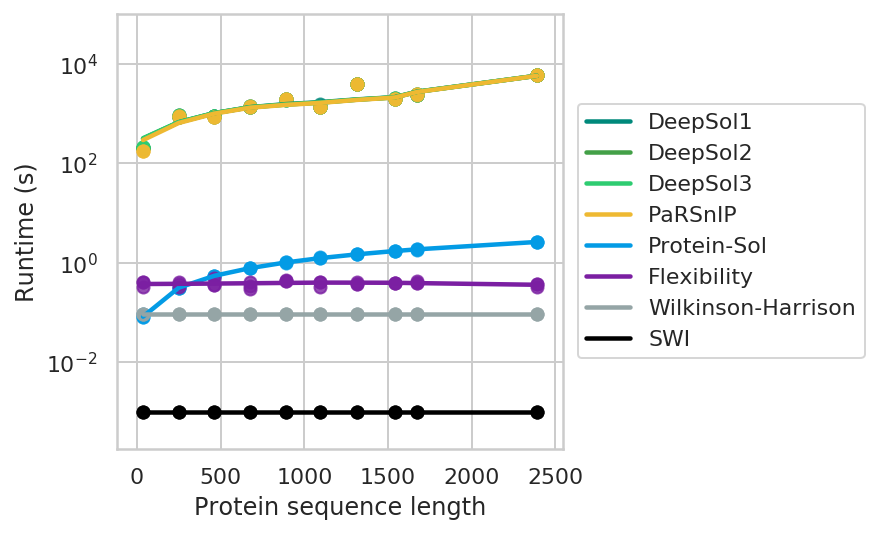

In [44]:
%matplotlib inline
# %config InlineBackend.figure_format = 'pdf'
%config InlineBackend.figure_format = 'retina'
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(4,4))
ax.set(yscale="log")
sns.regplot(x='Length', y='Runtime (s)', lowess=True, data=deepsol1, color='#00897B')
sns.regplot(x='Length', y='Runtime (s)', lowess=True, data=deepsol2, color='#43A047')
sns.regplot(x='Length', y='Runtime (s)', lowess=True, data=deepsol3, color='#2ECC71')
sns.regplot(x='Length', y='Runtime (s)', lowess=True, data=parsnip, color='#EEB932')
sns.regplot(x='Length', y='Runtime (s)', lowess=True, data=protein_sol, color='#039BE5')
sns.regplot(x='Length', y='Runtime (s)', lowess=True, data=flexibility, color='#7B1FA2')
sns.regplot(x='Length', y='Runtime (s)', lowess=True, data=wilkinson, color='#95A5A6')
sns.regplot(x='Length', y='Runtime (s)', lowess=True, data=swi, color='black')
ax.set(ylim=(None, 100000))
plt.xlabel('Protein sequence length')
plt.ylabel('Runtime (s)')
ax.legend(labels=['DeepSol1', 'DeepSol2', 'DeepSol3', \
                  'PaRSnIP', 'Protein-Sol', 'Flexibility', \
                  'Wilkinson-Harrison', 'SWI'], \
          loc='center right', bbox_to_anchor=(1.7, 0.5), ncol=1)
# plt.savefig('benchmark.pdf')

In [45]:
df = pd.concat([deepsol1, deepsol2, deepsol3, \
           parsnip, protein_sol, flexibility, \
           wilkinson, swi]).sort_values(['Tool', 'Accession']).reset_index(drop=True)

In [46]:
run = (z for z in cycle(list(range(0,3))))
run = pd.DataFrame({'Run': list(islice(run, 240))})

In [47]:
df = pd.concat([df, run], axis=1)
df['Runtime (hh:mm:ss)'] = pd.to_datetime(df['Runtime (s)'], unit='s').dt.time
df = df.reindex(sorted(df.columns), axis=1)

In [48]:
df.to_csv('benchmark.txt', sep='\t', index=None)